# Assignment 2: Cardiovascular Risk
Alex Reese, Scott Ratchford, Ben Fioresi
### Introduction
TODO

Only run this install command on Google Colab, and only once.

In [35]:
!pip install tensorflow_decision_forests

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import tensorflow_decision_forests as tfdf
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Custom class for simple collection of model performance
class PerformanceMetrics:
    """
    # Example usage of PerformanceMetrics (define a model first)
    metrics = PerformanceMetrics("Foo", model, "test_data.csv")
    """
    def __init__(self, name: str, model, test_dataframe) -> None:
        self.name = name
        # evaulates the model and saves key metrics

        if isinstance(model, tfdf.keras.RandomForestModel):
            # convert the testing data to TensorFlow dataset
            test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataframe, task=tfdf.keras.Task.CLASSIFICATION, label="DEATH_EVENT")
            # predict class values
            predictions_proba = model.predict(test_ds).flatten()
            predicted_classes = (predictions_proba > 0.5).astype(int)
        elif isinstance(model, DecisionTreeClassifier):
            test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_dataframe, task=tfdf.keras.Task.CLASSIFICATION, label="DEATH_EVENT")
            # predict class values
            predictions_proba = model.predict(test_dataframe.drop(columns=("DEATH_EVENT"))).flatten()
            predicted_classes = model.predict(test_dataframe.drop(columns=("DEATH_EVENT")))
        elif isinstance(model, Pipeline) or isinstance(model, GridSearchCV):
            model.fit(test_dataframe.drop(columns=("DEATH_EVENT")), test_dataframe["DEATH_EVENT"].values)
            # predict class values
            predictions_proba = model.predict(test_dataframe.drop(columns=("DEATH_EVENT"))).flatten()
            predicted_classes = model.predict(test_dataframe.drop(columns=("DEATH_EVENT")))
        else:
            raise TypeError("model is not of type tfdf.keras.RandomForestModel, sklearn.tree.DecisionTreeClassifier, or sklearn.pipeline.Pipeline")

        # perform calculations to determine metrics
        true_labels = test_dataframe["DEATH_EVENT"].values
        # the important evaluation metrics
        self.accuracy = accuracy_score(true_labels, predicted_classes)
        self.precision = precision_score(true_labels, predicted_classes)
        self.recall = recall_score(true_labels, predicted_classes)
        self.f1 = f1_score(true_labels, predicted_classes)
        self.roc_auc = roc_auc_score(true_labels, predictions_proba)  # Note: Here we use the probabilities, not the thresholded predictions
        self.conf_matrix = confusion_matrix(true_labels, predicted_classes)
    
    def __str__(self) -> str:
        return f"{self.name} Performance Metrics\nAccuracy: {self.accuracy}\nPrecision: {self.precision}\nRecall: {self.recall}\nF1 Score: {self.f1}\nROC AUC: {self.roc_auc}\nConfusion Matrix:\n{self.conf_matrix}"



## Loading the Dataset

In [37]:
import pandas as pd
import math

# Load the dataset into a dataframe
data = pd.read_csv('Heart_failure_dataset.csv', encoding = "utf-8-sig")

int_cols = ("age", "creatine_phosphokinase", "ejection_fraction", "platelets", "serum_sodium", "time")
bool_cols = ("anaemia", "diabetes", "high_blood_pressure", "sex", "smoking")
# Delete the cells containing data that seems errorneous
for col_name, col in data.items():
    if col_name in int_cols:
        for cell in col:
            if not math.isclose(cell, int(cell)):   # drop cells with decimals
                cell = None
    if col_name in bool_cols:
        for cell in col:
            if cell != 0 and cell != 1:   # drop cells that aren't 0 or 1
                cell = None

### Train/Test Split

We use the same train/test data split for all models. 75% of the data set is used for training models, while 25% is reserved for testing. The training and test data are saved in their respective CSV files.

In [38]:
from sklearn.model_selection import train_test_split

# Drop columns that won't be used for training
# data = data.drop(columns=['DEATH_EVENT'])

# Split data into training and validation sets                              # stratify insures equal ratio
train_data, test_data = train_test_split(data, test_size=0.25, random_state=55)  # , stratify=data['Age']

# Save the training and test datasets to CSV files
train_data.to_csv('train_data.csv', index=False, encoding="utf-8-sig")
test_data.to_csv('test_data.csv', index=False, encoding="utf-8-sig")

## Data Visualization

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style("whitegrid")

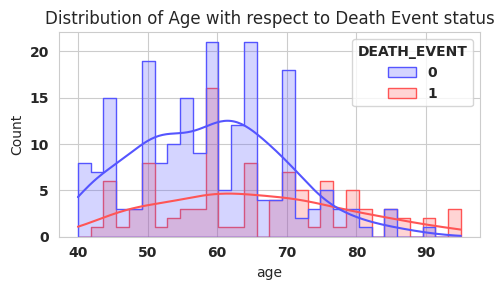

In [40]:
# Plot the distribution of the 'age' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='age', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Age with respect to Death Event status')
plt.tight_layout()
plt.show()

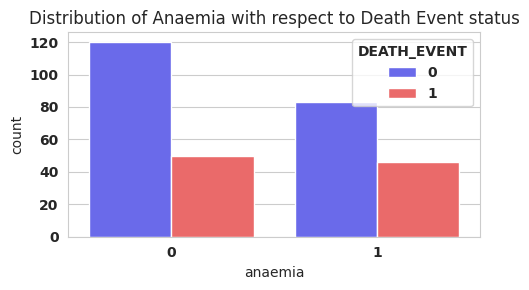

In [41]:
# Plot the distribution of the 'anaemia' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='anaemia', hue='DEATH_EVENT', palette='seismic', order=data['anaemia'].value_counts().index)
plt.title('Distribution of Anaemia with respect to Death Event status')
plt.tight_layout()
plt.show()

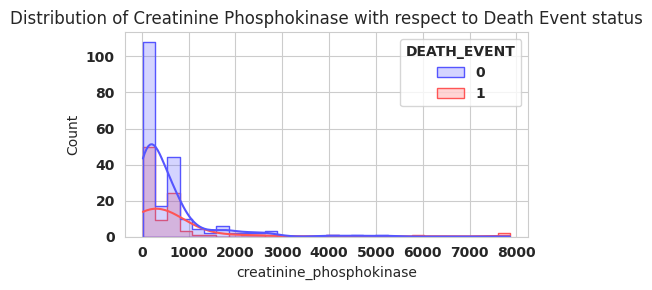

In [42]:
# Plot the distribution of the 'creatinine_phosphokinase' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='creatinine_phosphokinase', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Creatinine Phosphokinase with respect to Death Event status')
plt.tight_layout()
plt.show()

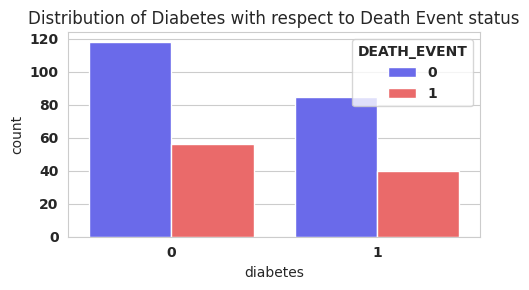

In [43]:
# Plot the distribution of the 'diabetes' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='diabetes', hue='DEATH_EVENT', palette='seismic', order=data['diabetes'].value_counts().index)
plt.title('Distribution of Diabetes with respect to Death Event status')
plt.tight_layout()
plt.show()

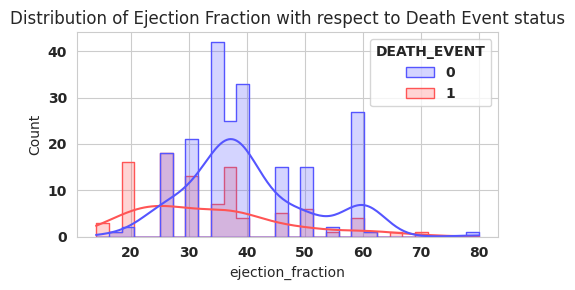

In [44]:
# Plot the distribution of the 'ejection_fraction' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='ejection_fraction', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Ejection Fraction with respect to Death Event status')
plt.tight_layout()
plt.show()

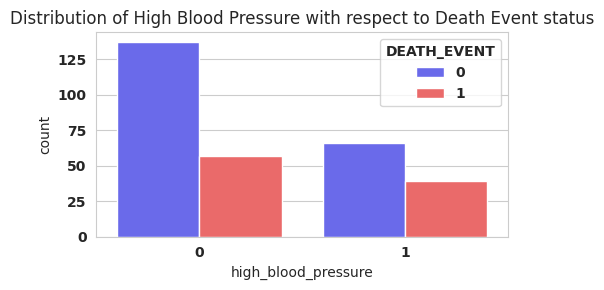

In [45]:
# Plot the distribution of the 'high_blood_pressure' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='high_blood_pressure', hue='DEATH_EVENT', palette='seismic', order=data['diabetes'].value_counts().index)
plt.title('Distribution of High Blood Pressure with respect to Death Event status')
plt.tight_layout()
plt.show()

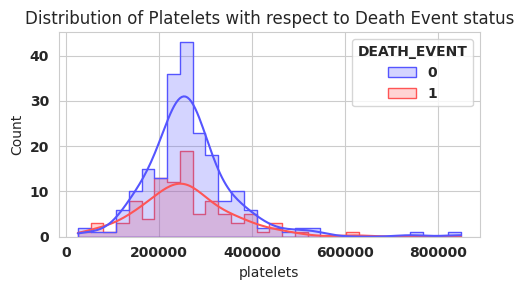

In [46]:
# Plot the distribution of the 'platelets' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='platelets', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Platelets with respect to Death Event status')
plt.tight_layout()
plt.show()

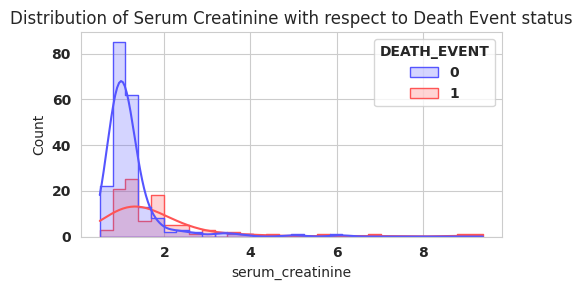

In [47]:
# Plot the distribution of the 'serum_creatinine' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='serum_creatinine', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Serum Creatinine with respect to Death Event status')
plt.tight_layout()
plt.show()

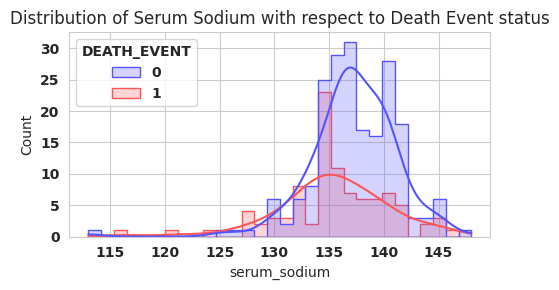

In [48]:
# Plot the distribution of the 'serum_sodium' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='serum_sodium', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Serum Sodium with respect to Death Event status')
plt.tight_layout()
plt.show()

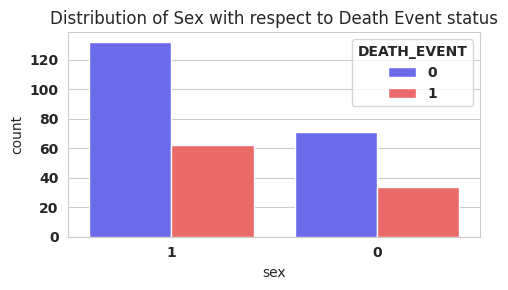

In [49]:
# Plot the distribution of the 'sex' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='sex', hue='DEATH_EVENT', palette='seismic', order=data['sex'].value_counts().index)
plt.title('Distribution of Sex with respect to Death Event status')
plt.tight_layout()
plt.show()

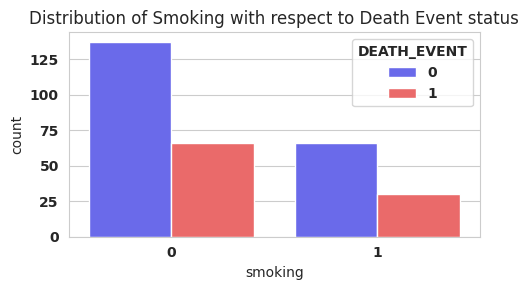

In [50]:
# Plot the distribution of the 'smoking' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='smoking', hue='DEATH_EVENT', palette='seismic', order=data['smoking'].value_counts().index)
plt.title('Distribution of Smoking with respect to Death Event status')
plt.tight_layout()
plt.show()

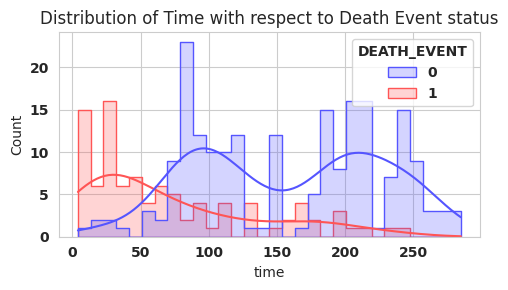

In [51]:
# Plot the distribution of the 'time' column with respect to the 'DEATH_EVENT' column
plt.figure(figsize=(5, 3))
sns.histplot(data=data, x='time', hue='DEATH_EVENT', palette='seismic', bins=30, kde=True, element="step")
plt.title('Distribution of Time with respect to Death Event status')
plt.tight_layout()
plt.show()

# Random Forest Model

### Training Option 1 - Default Hyperparameters

In [52]:
import tensorflow_decision_forests as tfdf

# Load the training dataset
dataset_df = pd.read_csv('train_data.csv', encoding = "utf-8-sig")

# Convert the training data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="DEATH_EVENT")

# Create a Random Forest model
model = tfdf.keras.RandomForestModel()
model.fit(train_ds)

# model.save('trained_model')

Use /tmp/tmpr_xoag85 as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.947157. Found 224 examples.
Training model...
Model trained in 0:00:00.088146
Compiling model...


[INFO 23-11-29 14:38:19.5674 CST kernel.cc:1243] Loading model from path /tmp/tmpr_xoag85/model/ with prefix e3d0d764d8764241
[INFO 23-11-29 14:38:19.5854 CST decision_forest.cc:660] Model loaded with 300 root(s), 9888 node(s), and 12 input feature(s).
[INFO 23-11-29 14:38:19.5855 CST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-11-29 14:38:19.5855 CST kernel.cc:1075] Use fast generic engine


Model compiled.


### Training Option 2 - Search for Hyperparameters

In [53]:
# Load the training dataset
dataset_df = pd.read_csv('train_data.csv', encoding = "utf-8-sig")

# Convert the training data to TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset_df, label="DEATH_EVENT")

# Configure the tuner
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("num_candidate_attributes_ratio", [x / 10.0 for x in range(-10, 10)])
tuner.choice("max_depth", list(range(3, 200)))
tuner.choice("num_trees", list(range(10, 500)))

# Configure and train the model.
model = tfdf.keras.RandomForestModel(tuner=tuner)
model.fit(train_ds)

Use /tmp/tmpq3dyxfhk as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.280285. Found 224 examples.
Training model...
Model trained in 0:00:05.128506
Compiling model...


[INFO 23-11-29 14:38:25.3015 CST kernel.cc:1243] Loading model from path /tmp/tmpq3dyxfhk/model/ with prefix 4459cfb3236d462b
[INFO 23-11-29 14:38:25.3085 CST decision_forest.cc:660] Model loaded with 119 root(s), 3965 node(s), and 12 input feature(s).
[INFO 23-11-29 14:38:25.3085 CST kernel.cc:1075] Use fast generic engine


Model compiled.


### Evaluating the Random Forest Model

In [54]:
# Load the testing dataset
temp_df = pd.read_csv("test_data.csv", encoding = "utf-8-sig")
# Create instance of PerformanceMetrics
rf_metrics = PerformanceMetrics("Random Forest Classifier", model, temp_df)
print(str(rf_metrics))

1/1 [==============================] - 0s 57ms/step
Random Forest Classifier Performance Metrics
Accuracy: 0.8266666666666667
Precision: 0.7222222222222222
Recall: 0.6190476190476191
F1 Score: 0.6666666666666666
ROC AUC: 0.8853615520282188
Confusion Matrix:
[[49  5]
 [ 8 13]]


# Decision Tree Classifier (Decision Forest)

In [55]:
!pip install tensorflow_decision_forests

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Training Decision Tree Model

In [56]:
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_leaf_nodes=None, max_depth=None, random_state=0)
# train decision tree model to predict DEATH_EVENT
dt_model.fit(train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values)

DecisionTreeClassifier(random_state=0)

## Visualizing Decision Tree Process

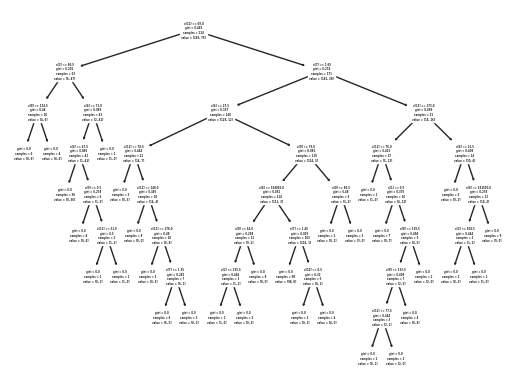

In [57]:
tree.plot_tree(dt_model)
plt.show()

In [58]:
!pip install dtreeviz

/bin/bash: /home/scott/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


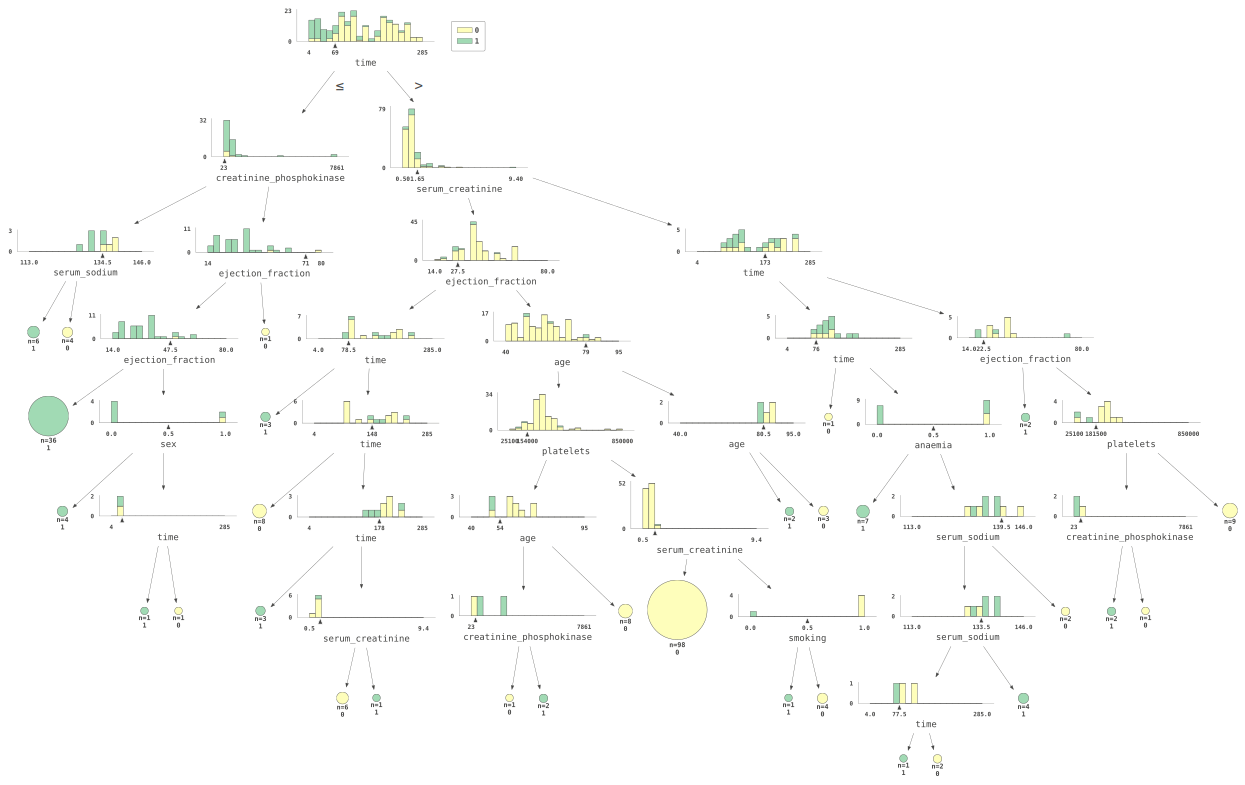

In [59]:
import dtreeviz

viz_cmodel = dtreeviz.model(dt_model, train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values, class_names=("0", "1"), feature_names=train_data.columns)
viz_cmodel.view(fontname="monospace")

## Evaluating Decision Tree Classifier Performance

In [60]:
temp_df = pd.DataFrame(test_data)
dt_metrics = PerformanceMetrics("Decision Tree Classifier", dt_model, temp_df)
print(str(dt_metrics))

Decision Tree Classifier Performance Metrics
Accuracy: 0.7733333333333333
Precision: 0.5769230769230769
Recall: 0.7142857142857143
F1 Score: 0.6382978723404256
ROC AUC: 0.7552910052910053
Confusion Matrix:
[[43 11]
 [ 6 15]]


# K-Nearest Neighbor Classifier

### Option 1 - Default Hyperparameters

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

knn_model = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

knn_model.fit(train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values)


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=1))])

### Option 2 - Hyperparameter Search

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_adv_model = KNeighborsClassifier()
# hyperparameters to try
n_neighbors = range(1, 11)
algorithm = ("ball_tree", "kd_tree", "brute")
leaf_size = range(25, 36)
p = range(2, 5)
knn_hyperparameters = dict(n_neighbors=n_neighbors, algorithm=algorithm, leaf_size=leaf_size, p=p)

knn_clf = GridSearchCV(knn_adv_model, knn_hyperparameters)

knn_adv_model = knn_clf.fit(train_data.drop(columns=("DEATH_EVENT")), train_data["DEATH_EVENT"].values)


/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 246, in predict

# Comparison
TODO

## All Model Evaluations

In [64]:
# Load the testing dataset
temp_df = pd.read_csv("test_data.csv", encoding = "utf-8-sig")

# Random Forest Classifier
rf_metrics = PerformanceMetrics("Random Forest Classifier", model, temp_df)
print(str(rf_metrics))

# Decision Tree Classifier
dt_metrics = PerformanceMetrics("Decision Tree Classifier", dt_model, temp_df)
print(str(dt_metrics))

# K-Nearest Neighbors Classifier
knn_metrics = PerformanceMetrics("K-Nearest Neighbors Classifier", knn_model, temp_df)
print(str(knn_metrics))

1/1 [==============================] - 0s 89ms/step
Random Forest Classifier Performance Metrics
Accuracy: 0.8266666666666667
Precision: 0.7222222222222222
Recall: 0.6190476190476191
F1 Score: 0.6666666666666666
ROC AUC: 0.8853615520282188
Confusion Matrix:
[[49  5]
 [ 8 13]]
Decision Tree Classifier Performance Metrics
Accuracy: 0.7733333333333333
Precision: 0.5769230769230769
Recall: 0.7142857142857143
F1 Score: 0.6382978723404256
ROC AUC: 0.7552910052910053
Confusion Matrix:
[[43 11]
 [ 6 15]]
K-Nearest Neighbors Classifier Performance Metrics
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0
Confusion Matrix:
[[54  0]
 [ 0 21]]


In [67]:
# K-Nearest Neighbors Advanced Classifier
knn_adv_metrics = PerformanceMetrics("K-Nearest Neighbors Advanced Classifier", knn_adv_model, temp_df)
print(str(knn_adv_metrics))

/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 246, in predict

K-Nearest Neighbors Advanced Classifier Performance Metrics
Accuracy: 0.8533333333333334
Precision: 0.8125
Recall: 0.6190476190476191
F1 Score: 0.7027027027027026
ROC AUC: 0.7817460317460317
Confusion Matrix:
[[51  3]
 [ 8 13]]


/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
                             ^^^^^^^^^^^^^^^
  File "/home/scott/miniconda3/lib/python3.11/site-packages/sklearn/neighbors/_classification.py", line 246, in predict

# References
1. [Tensorflow Decision Forest Tutorial](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab)
2. [KNN Colab Example](https://colab.research.google.com/github/FreeOfConfines/ExampleNNWithKerasAndTensorflow/blob/master/K_Nearest_Neighbor_Classification_with_Tensorflow_on_Fashion_MNIST_Dataset.ipynb)
3. [scikit-learn Decision Tree Example](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py)
4. [Decision Tree Visualizations](https://www.kaggle.com/code/immu123/decision-tree-visualization-with-dtreeviz)
5. [KNN Scikit Documentation](https://scikit-learn.org/stable/modules/neighbors.html)
6. [KNN Scikit Example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py)
7. [scikit-learn Hyperparameter Search](https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f)